# Comparison to Kruk (2018)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.coordinates import SkyCoord
import astropy.units as u

In [2]:
gal_angle_df = pd.read_csv('lib/gal-metadata.csv', index_col=0)

In [3]:
models = pd.read_pickle('lib/models.pickle')

In [4]:
sd = pd.read_csv('../source_files/Kruk2018_Table2_Table3.csv')
sd_coords = SkyCoord(ra=sd['ra']*u.degree, dec=sd['dec']*u.degree)

In [5]:
matches = pd.DataFrame([], columns=sd.columns)
for subject_id in gal_angle_df.index.values:
  gal = gal_angle_df.loc[subject_id]
  sep = sd_coords.separation(
    SkyCoord(ra=gal['RA']*u.degree, dec=gal['DEC']*u.degree)
  )
  idxmin_sep = np.argmin(sep)
  if sep[idxmin_sep] < 1 * u.arcsec:
    matches.loc[subject_id] = sd.iloc[idxmin_sep]

In [6]:
def get_fit_component_string(model):
  ks = ('disk', 'bar', 'bulge')
  return '+'.join(
    k for k in ks
    if model[k] is not None
  ).replace('disk', 'disc')

In [7]:
bi_models_string = models['tuned_best_individual']\
    .apply(get_fit_component_string)
agg_models_string = models['tuned_aggregate']\
    .apply(get_fit_component_string)

In [8]:
same_comp_info = {
  'gzb': (bi_models_string == agg_models_string),
  'bi': (
    matches['Fit_components']
    == bi_models_string.reindex(matches.index)
  ),
  'agg': (
    matches['Fit_components']
    == agg_models_string.reindex(matches.index)
  )
}

In [9]:
print('\n'.join(
    '{}: {:.4f}'.format(k, v.sum() / v.count())
    for k, v in same_comp_info.items()
))

gzb: 0.5912
bi: 0.2143
agg: 0.3571


In [10]:
def get_val(comp, param):
    def _f(m):
        try:
            if m[comp] is not None:
                return m[comp][param]
        except KeyError:
            pass
        return np.nan
    return _f

k = 'tuned_aggregate'
disk_ba = models[k].apply(get_val('disk', 'q'))
bulge_ba = models[k].apply(get_val('bulge', 'q'))
bar_ba = models[k].apply(get_val('bar', 'q'))
disk_re = models[k].apply(get_val('disk', 'Re'))
bulge_re = models[k].apply(get_val('bulge', 'Re'))
bar_re = models[k].apply(get_val('bar', 'Re'))

We will clean models where the disk effective radius has diverged, or the disk effective radius is larger than the bulge's:

In [11]:
# we have one case where disk effective radius has diverged
bad_indices = disk_re.index[(disk_re > 1000) ^ (disk_re < bulge_re) ^ (bulge_re == 0)]
matches_cleaned = matches.drop(bad_indices, errors='ignore')
matches_bad = matches.reindex(bad_indices).dropna()

In [12]:
errors = pd.read_csv('lib/errors.csv', index_col=0, header=[0, 1])
disk_error = errors['disk']
bulge_error = errors['bulge']
bar_error = errors['bar']

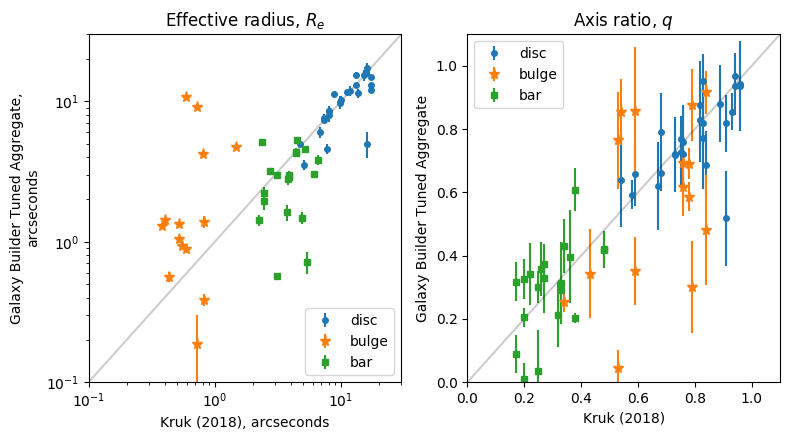

In [13]:
f, axs = plt.subplots(ncols=2, figsize=(8, 4.5), dpi=100)
markers = ('o', '*', 's')
sizes = np.array((1, 2, 1)) * 4
ax = axs[0]
ax.errorbar(
    matches_cleaned['re_disc'].replace(0, np.nan) * 0.396,
    disk_re.reindex(matches_cleaned.index) * 0.396,
    yerr=disk_error['Re'].reindex(matches_cleaned.index),
    fmt=markers[0], markersize=sizes[0],
    label='disc',
)
ax.errorbar(
    matches_cleaned['re_bulge'].replace(0, np.nan) * 0.396,
    bulge_re.reindex(matches_cleaned.index) * 0.396,
    yerr=bulge_error['Re'].reindex(matches_cleaned.index),
    fmt=markers[1], markersize=sizes[1],
    label='bulge',
)
ax.errorbar(
    matches_cleaned['re_bar'].replace(0, np.nan) * 0.396,
    bar_re.reindex(matches_cleaned.index) * 0.396,
    yerr=bar_error['Re'].reindex(matches_cleaned.index),
    fmt=markers[2], markersize=sizes[2],
    label='bar',
)
ax.add_line(plt.Line2D((0.01, 1E4), (0.01, 1E4), c='k', alpha=0.2))
ax.set_title(r'Effective radius, $R_e$')
ax.set_xlabel('Kruk (2018), arcseconds')
ax.set_ylabel('Galaxy Builder Tuned Aggregate,\narcseconds')

plt.sca(ax)
plt.xscale('log')
plt.yscale('log')
plt.xlim(0.1, 30)
plt.ylim(0.1, 30)
plt.legend()

ax = axs[1]
ax.errorbar(
    matches_cleaned['ba_disc'].replace(0, np.nan),
    disk_ba.reindex(matches_cleaned.index),
    yerr=disk_error['q'].reindex(matches_cleaned.index),
    fmt=markers[0], markersize=sizes[0],
    label='disc',
)
ax.errorbar(
    matches_cleaned['ba_bulge'].replace(0, np.nan),
    bulge_ba.reindex(matches_cleaned.index),
    yerr=bulge_error['q'].reindex(matches_cleaned.index),
    fmt=markers[1], markersize=sizes[1],
    label='bulge',
)
ax.errorbar(
    matches_cleaned['ba_bar'].replace(0, np.nan),
    bar_ba.reindex(matches_cleaned.index),
    yerr=bar_error['q'].reindex(matches_cleaned.index),
    fmt=markers[2], markersize=sizes[2],
    label='bar',
)
ax.add_line(plt.Line2D((0, 2), (0, 2), c='k', alpha=0.2))
ax.set_xlim(0, 1.1)
ax.set_ylim(0, 1.1)
ax.set_title(r'Axis ratio, $q$')
ax.set_xlabel('Kruk (2018)')
ax.set_ylabel('Galaxy Builder Tuned Aggregate')
plt.sca(ax)
plt.legend()
plt.tight_layout()
plt.savefig(
    'method-paper-plots/sd_comp_comparison.pdf',
    bbox_inches='tight'
);

What was the sample standard deviation on $\mathrm{Sandor} - \mathrm{Galaxy\ Builder}$?

Text(0.5, 0, 'Bar axis ratio, $q$')

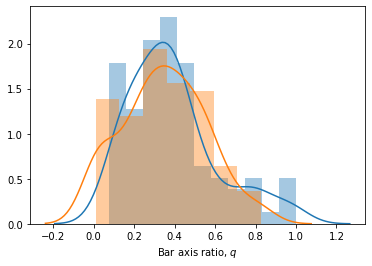

In [15]:
sns.distplot(
    models['best_individual']
        .apply(get_val('bar', 'q')).dropna()
)
sns.distplot(
    models['tuned_aggregate']
        .apply(get_val('bar', 'q')).dropna()
)
plt.xlabel('Bar axis ratio, $q$')

In [16]:
print('Disc:  {:.4f} arcseconds'.format((
    matches['re_disc'].replace(0, np.nan)
    - disk_re.reindex(matches.index)
).dropna().std()))
print('Bulge: {:.4f} arcseconds'.format((
    matches['re_bulge'].replace(0, np.nan)
    - bulge_re.reindex(matches.index)
).dropna().std()))
print('Bar:   {:.4f} arcseconds'.format((
    matches['re_bar'].replace(0, np.nan)
    - bar_re.reindex(matches.index)
).dropna().std()))

Disc:  6.0506 arcseconds
Bulge: 7.7359 arcseconds
Bar:   3.9953 arcseconds


Text(0.5, 0, 'Kruk (2018) axis ratio - Galaxy builder axis ratio')

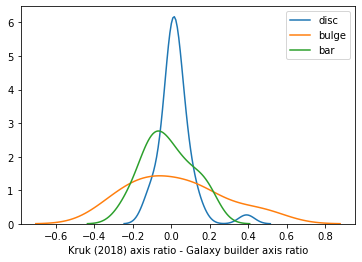

In [17]:
sns.kdeplot((
    matches['ba_disc'].replace(0, np.nan)
    - disk_ba.reindex(matches.index)
).dropna(), label='disc')
sns.kdeplot((
    matches['ba_bulge'].replace(0, np.nan)
    - bulge_ba.reindex(matches.index)
).dropna(), label='bulge')
sns.kdeplot((
    matches['ba_bar'].replace(0, np.nan)
    - bar_ba.reindex(matches.index)
).dropna(), label='bar')
plt.xlabel('Kruk (2018) axis ratio - Galaxy builder axis ratio')

Text(0.5, 0, 'Bulge Sérsic index')

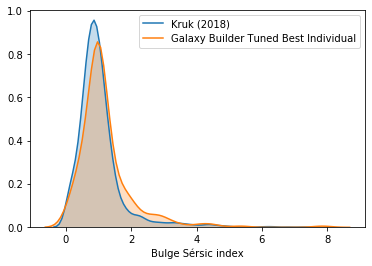

In [18]:
sns.kdeplot(
    sd['n_bulge'][sd['n_bulge'] > 0].rename('Kruk (2018)'),
    shade=True
)
sns.kdeplot(
    models[k].apply(get_val('bulge', 'n')).dropna().rename('Galaxy Builder Tuned Best Individual'),
    shade=True
)
plt.xlabel('Bulge Sérsic index')